In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in @defVar(::Symbol, ::Vararg{Any,N}) at /home/jzh/.julia/v0.5/JuMP/src/deprecated.jl:24
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/jzh/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /home/jzh/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[3], in expression starting on line 1


setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Jan_weekday_AM.txt")
demands = Dict()
n = 8  # number of nodes
for i = 1:n
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (parse(Int, OD_demand[1]), parse(Int, OD_demand[2])), parse(Float64, split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{Any,Any} with 64 entries:
  (3,6) => 649.735
  (4,4) => 0.0
  (3,1) => 380.827
  (4,5) => 471.006
  (2,4) => 1507.94
  (6,5) => 195.297
  (8,4) => 1460.9
  (1,2) => 409.199
  (5,1) => 896.012
  (3,4) => 694.961
  (8,2) => 271.056
  (2,3) => 177.085
  (2,6) => 156.247
  (5,4) => 335.102
  (2,1) => 456.972
  (2,5) => 230.391
  (8,5) => 121.103
  (1,4) => 636.049
  (2,8) => 269.001
  (5,8) => 244.715
  (4,8) => 1691.05
  (7,8) => 243.348
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 1529.59
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Jan_dict = readall("../temp_files/link_day_minute_Jan_dict_JSON_adjusted.json");
link_day_minute_Jan_dict = replace(link_day_minute_Jan_dict, "NaN", 0);

link_day_minute_Jan_dict = JSON.parse(link_day_minute_Jan_dict);

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in readall(::String, ::Vararg{String,N}) at ./deprecated.jl:30
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/jzh/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /home/jzh/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[11], in expression starting on line 3


In [12]:
# week_day_Jan_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30, 31]

# training set 1
week_day_Jan_list_1 = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19]

# training set 2
week_day_Jan_list_2 = [2, 3, 4, 5, 6, 9, 10, 20, 23, 24, 25, 26, 27, 30, 31]

# training set 3
week_day_Jan_list_3 = [11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30, 31]


arcs_1 = Dict[]
for j in week_day_Jan_list_1
    arcs_1_ = Dict()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jan_dict[key]["init_node"]
        termNode = link_day_minute_Jan_dict[key]["term_node"]
        capacity = link_day_minute_Jan_dict[key]["AM_capac"]
        freeflowtime = link_day_minute_Jan_dict[key]["free_flow_time"]
        flow = link_day_minute_Jan_dict[key]["AM_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict[]
for j in week_day_Jan_list_2
    arcs_2_ = Dict()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jan_dict[key]["init_node"]
        termNode = link_day_minute_Jan_dict[key]["term_node"]
        capacity = link_day_minute_Jan_dict[key]["AM_capac"]
        freeflowtime = link_day_minute_Jan_dict[key]["free_flow_time"]
        flow = link_day_minute_Jan_dict[key]["AM_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict[]
for j in week_day_Jan_list_3
    arcs_3_ = Dict()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jan_dict[key]["init_node"]
        termNode = link_day_minute_Jan_dict[key]["term_node"]
        capacity = link_day_minute_Jan_dict[key]["AM_capac"]
        freeflowtime = link_day_minute_Jan_dict[key]["free_flow_time"]
        flow = link_day_minute_Jan_dict[key]["AM_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)
flow_data_2 = Array(Float64, length(arcs_2[1]), numData)
flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [14]:
demand_data

Dict{Any,Any} with 64 entries:
  (3,6) => [649.735,649.735,649.735,649.735,649.735,649.735,649.735,649.735,649…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [380.827,380.827,380.827,380.827,380.827,380.827,380.827,380.827,380…
  (4,5) => [471.006,471.006,471.006,471.006,471.006,471.006,471.006,471.006,471…
  (2,4) => [1507.94,1507.94,1507.94,1507.94,1507.94,1507.94,1507.94,1507.94,150…
  (6,5) => [195.297,195.297,195.297,195.297,195.297,195.297,195.297,195.297,195…
  (8,4) => [1460.9,1460.9,1460.9,1460.9,1460.9,1460.9,1460.9,1460.9,1460.9,1460…
  (1,2) => [409.199,409.199,409.199,409.199,409.199,409.199,409.199,409.199,409…
  (5,1) => [896.012,896.012,896.012,896.012,896.012,896.012,896.012,896.012,896…
  (3,4) => [694.961,694.961,694.961,694.961,694.961,694.961,694.961,694.961,694…
  (8,2) => [271.056,271.056,271.056,271.056,271.056,271.056,271.056,271.056,271…
  (2,3) => [177.085,177.085,177.085,177.085,177.085,177.085,177.085,177.085,177…
  (2,6) =

In [15]:
flow_data_3

24×14 Array{Float64,2}:
 3223.7   4540.74  4665.93  2868.32  5153.68  …  3740.89   3846.48  4699.61
 1876.72  4121.32  3776.23  2114.28  3688.56     3975.0    3121.98  3599.25
 3271.31  4194.6   3514.07  1316.77  3167.82     3935.05   4059.81  3368.0 
 1819.29  3009.61  1640.84  1359.91  2117.6      1516.8    1766.67  1567.9 
 1466.36  3014.88  2528.16  1597.43  2708.45     1089.23   2193.46  2632.22
 4250.32  5288.52  5523.1   2756.73  5578.27  …  4265.76   4098.49  4967.55
 2364.71  3228.2   2422.97  1817.95  2284.16     2771.3    2451.16  2108.85
 2268.05  3384.42  2929.57  1787.02  3250.35     2054.37   2446.59  2557.75
 3610.83  4999.3   3567.83  1378.89  4880.51     4301.67   3211.86  4064.95
 1783.12  2821.23  1904.68  1424.51  1074.79      728.88   1298.78  1031.83
 4324.43  4975.1   4250.02  2093.98  3915.99  …  4213.33   4310.03  3545.99
 1651.61  2239.48  1946.21  1614.18  2001.01      756.189  1312.04  1312.22
 2824.58  5323.01  5894.15  2007.53  6146.24     4581.17   3780.

In [16]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [17]:
#include("trafficCval.jl")

coeffs_dict_Jan_AM = Dict()

deg_grid = 4:8
c_grid = .5:.5:3.
lamb_grid = 10. .^(-3:4)

# deg_grid = 8
# c_grid = .5
# lamb_grid = 10. .^(4)

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Jan_AM[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Jan_AM[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Jan_AM[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [18]:
outfile = open("../temp_files/coeffs_dict_Jan_AM.json", "w")

JSON.print(outfile, coeffs_dict_Jan_AM)

close(outfile)

In [19]:
coeffs_dict_Jan_AM_ = readall("../temp_files/coeffs_dict_Jan_AM.json")
coeffs_dict_Jan_AM_ = JSON.parse(coeffs_dict_Jan_AM_)

Dict{String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => Any[1.0,0.0203409,0.0126615,0.00486339,0.00120787,0.00…
  "(5,0.5,100.0,3)"   => Any[1.0,0.00860992,0.0204373,0.0192197,0.016244,0.0027…
  "(6,1.5,10.0,3)"    => Any[1.0,0.0219364,0.0108461,0.00320143,0.000657072,3.7…
  "(6,2.0,0.1,2)"     => Any[1.0,0.0106751,0.00938484,0.00287299,-0.000472848,-…
  "(4,0.5,1000.0,1)"  => Any[1.0,0.0133816,0.0235481,0.0188176,0.00648718]
  "(6,2.0,0.01,1)"    => Any[1.0,0.131069,-0.344586,0.351485,-0.0585132,-0.0601…
  "(8,1.5,0.01,1)"    => Any[1.0,0.133242,-0.342353,0.222411,0.479842,-1.099,1.…
  "(5,1.5,1.0,1)"     => Any[1.0,0.0452853,-0.00689622,-0.0140489,-0.00505853,-…
  "(8,2.5,0.001,2)"   => Any[1.0,0.00714529,0.0274521,-0.0127962,-0.0254812,0.0…
  "(4,2.0,0.1,1)"     => Any[1.0,0.0631017,-0.05633,0.00905622,0.00398584]
  "(5,1.0,1000.0,2)"  => Any[1.0,0.0105543,0.00876997,0.00394137,0.00112106,9.1…
  "(4,2.0,0.1,2)"     => Any[1.0,0.0134365,0.00363151,0.000658328,5.5386e-5]
  "(5,2.0

In [20]:
coeffs_dict_Jan_AM_["(8,0.5,10000.0,1)"]

9-element Array{Any,1}:
  1.0       
 -0.00335126
  0.0574638 
 -0.194919  
  0.622268  
 -0.905452  
  0.941375  
 -0.47105   
  0.109571  

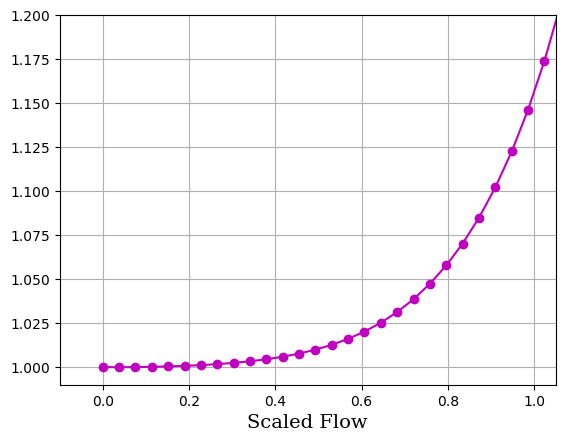

In [21]:
using PyPlot

fcoeffs = coeffs_dict_Jan_AM_["(8,0.5,10000.0,1)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

PyPlot.plot(xs, ys, "o-m", label="Jan_AM")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = Dict("family"=>"serif","color"=>"k","weight"=>"normal","size"=>14)

xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Jan_AM.pdf")